# Temperley's Probabilistic Key Estimation



In [1]:
import numpy as np
import partitura

import matplotlib.pyplot as plt
from scipy.stats import mode

from key_profiles import (
    build_key_profile_matrix, 
    key_prof_maj_kk,
    key_prof_min_kk,
    key_prof_maj_cbms,
    key_prof_min_cbms,
    key_prof_maj_kp,
    key_prof_min_kp,
    MAJOR_KEYS,
    KEYS
)

Here are different pitch distributions for major and minor keys

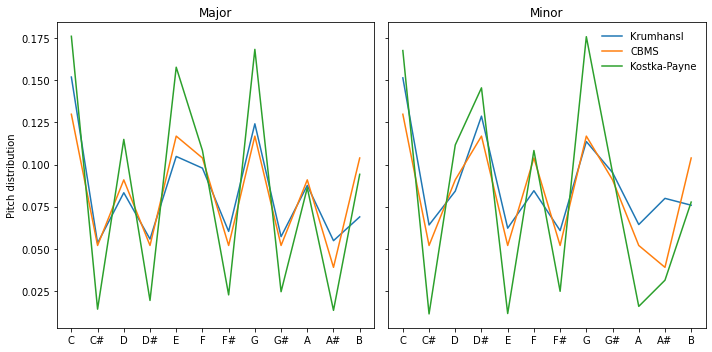

In [2]:
pitch_profiles = [
    (key_prof_maj_kk, key_prof_min_kk, "Krumhansl"),
    (key_prof_maj_cbms, key_prof_min_cbms, "CBMS"),
    (key_prof_maj_kp, key_prof_min_kp, "Kostka-Payne")
]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

for pmaj, pmin, profile in pitch_profiles:
    ax1.plot(pmaj / pmaj.sum(), label=profile)
    ax2.plot(pmin / pmaj.sum(), label=profile)
ax1.set_title("Major")
ax2.set_title("Minor")
ax1.set_xticks(ticks=np.arange(12))
ax1.set_xticklabels(MAJOR_KEYS)
ax2.set_xticks(ticks=np.arange(12))
ax2.set_xticklabels(MAJOR_KEYS)
ax1.set_ylabel("Pitch distribution")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

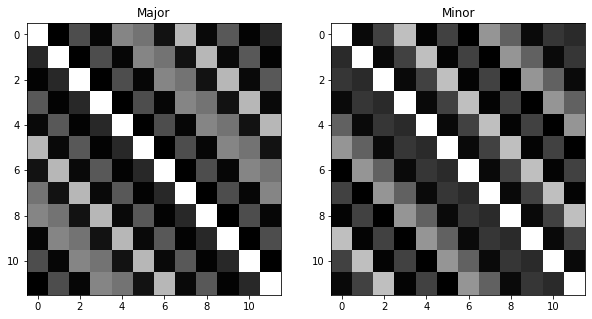

In [9]:
key_profile_matrix = build_key_profile_matrix("kk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Major")
ax1.imshow(key_profile_matrix[:12], aspect="auto", cmap="gray")
ax2.set_title("Minor")
ax2.imshow(key_profile_matrix[12:], aspect="auto", cmap="gray")

In [4]:
from hmm import HMM, ConstantTransitionModel, ObservationModel


class KeyProfileObservationModel(ObservationModel):
    def __init__(self, key_profile_matrix="kp"):
        super().__init__()
        if isinstance(key_profile_matrix, str):
            self.key_profile_matrix = build_key_profile_matrix(key_profile_matrix)
        elif isinstance(key_profile_matrix, np.ndarray):
            assert(key_profile_matrix.shape == (24, 12))
            self.key_profile_matrix = key_profile_matrix
            
    def __call__(self, observation):
        if not self.use_log_probabilities:
            p_obs_given_key = np.array(
                [
                    np.prod((kp**observation)*(1-kp)**(1-observation))
                    for kp in self.key_profile_matrix
                ]
            )
            return p_obs_given_key
        else self.use_log_probabilities:
            
            log_p_obs_given_key = np.array(
                [
                    np.sum((observation*np.log(kp + 1e-10) +
                           np.log1p(- (kp + 1e-10)) * (1 - ob)
                           )
                    )
                ]
            )
            return np.log(p_obs_given_key)
            
            
observation_model = KeyProfileObservationModel()

(24, 12)


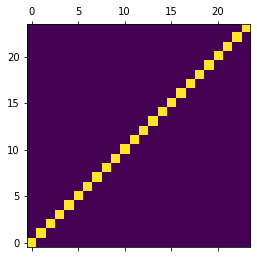

In [5]:
def compute_transition_probabilities(inertia_param=0.8):
    """
    Matrix of transition probabilities
    """
    modulation_prob = (1 - inertia_param)/23.
    A = (modulation_prob * (np.ones(24) - np.eye(24))
         + inertia_param * np.eye(24))

    return A

# How likely are going to stay in the same key
intertia_param = 0.8
transition_probabilities = compute_transition_probabilities()
key_profile_matrix = build_key_profile_matrix("kp")
print(key_profile_matrix.shape)

plt.matshow(transition_probabilities, aspect="auto", origin="lower")

transition_model = ConstantTransitionModel(transition_probabilities)

In [6]:
hmm = HMM(observation_model=observation_model, transition_model=transition_model)

C:\Users\silva\miniconda3\envs\musinf\lib\site-packages\partitura\io\importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=57 velocity=0 time=144
  warnings.warn("ignoring MIDI message %s" % msg)
C:\Users\silva\miniconda3\envs\musinf\lib\site-packages\partitura\io\importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=60 velocity=0 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
C:\Users\silva\miniconda3\envs\musinf\lib\site-packages\partitura\io\importmidi.py:164: UserWarning: ignoring MIDI message note_off channel=1 note=36 velocity=0 time=0
  warnings.warn("ignoring MIDI message %s" % msg)


['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
The key is C


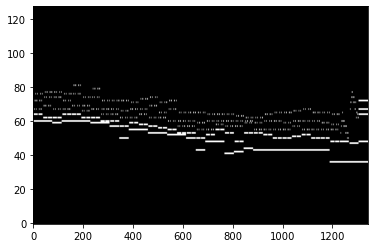

In [7]:
midi_fn = "./example_data/01.mid"
ppart = partitura.load_performance_midi(midi_fn)
note_array = ppart.note_array

time_div = 16
piano_roll = partitura.utils.compute_pianoroll(ppart, time_div=time_div).toarray()
# in seconds
win_size = 2

plt.imshow(piano_roll, origin="lower", aspect="auto", cmap="gray")

n_windows = int(np.ceil(piano_roll.shape[1] / (time_div * win_size)))

window_size = win_size * time_div

observations = np.zeros((n_windows, 12))
for win in range(n_windows):
    idx = slice(win * window_size, (win + 1) * window_size)
    segment = piano_roll[:, idx].sum(1)
    dist = np.zeros(12)
    pitch_idxs = np.where(segment != 0)[0]
    for pix in pitch_idxs:
        dist[pix % 12] += segment[pix]
    dist /= dist.sum()
    observations[win] = dist
    
path, log_lik = hmm.find_best_sequence(observations)

key_idx = int(mode(path).mode[0])

key = KEYS[key_idx]

print([KEYS[k] for k in path])

print(f"The key is {key}")

Let's put everything together!

In [21]:
def key_identification(fn, key_profiles="kp", inertia_param=0.8, piano_roll_resolution=16, win_size=2):
    """
    Probabilistic Key Identification
    
    Parameters
    ----------
    fn : filename
        MIDI file
    key_profiles: {"kp", "kk", "cbms"}
        Key profiles to use in the KeyProfileObservationModel (see definition in `key_profiles.py`)
    intertia_param: float
        Parameter between 0 and 1 indicating how likely it is that we will stay on the same key
    piano_roll_resolution: int
        Resolution of the piano roll (how many cells per second)
    win_size: float
        Window size in seconds
        
    Returns
    -------
    key : str
        The estimated key of the piece
    log_lik:
        The log-likelihood of the estimated key
    """
    # build observation model
    observation_model = KeyProfileObservationModel(key_profile_matrix=key_profiles)
    
    # Compute transition model
    transition_probabilities = compute_transition_probabilities(inertia_param=inertia_param)
    transition_model = ConstantTransitionModel(transition_probabilities)
    
    hmm = HMM(observation_model=observation_model,
              transition_model=transition_model)
    # Load score
    ppart = partitura.load_performance_midi(fn)
    note_array = ppart.note_array
    
    # Compute piano roll
    piano_roll = partitura.utils.compute_pianoroll(ppart, time_div=piano_roll_resolution).toarray()
    
    # Number of windows in the piano roll
    n_windows = int(np.ceil(piano_roll.shape[1] / (time_div * win_size)))
    
    # window size in cells
    window_size = win_size * time_div
    
    # Constuct observations (these are non-overlapping windows, but you can test other possibilities)
    observations = np.zeros((n_windows, 12))
    for win in range(n_windows):
        idx = slice(win * window_size, (win + 1) * window_size)
        segment = piano_roll[:, idx].sum(1)
        dist = np.zeros(12)
        pitch_idxs = np.where(segment != 0)[0]
        for pix in pitch_idxs:
            dist[pix % 12] += segment[pix]
        # Normalize pitch class distribution
        dist /= dist.sum()
        observations[win] = dist
    
    # Compute the sequence
    path, log_lik = hmm.find_best_sequence(observations)

    key_idx = int(mode(path).mode[0])

    key = KEYS[key_idx]
    
    return key, log_lik

In [24]:
key, log_lik = key_identification(midi_fn)


midi_dir = "/Users/carlos/experiment_data/wtc_audio/scores/musicxml/MIDI/"

midi_files = glob.glob(os.path.join(midi_dir, "*.mid"))
midi_files.sort()

keys = []
for i, fn in enumerate(midi_files):
    key, log_lik = key_identification(fn, "cbms")
    keys.append((i, key, log_lik))
    
for k in keys:
    print(k)

/Users/carlos/miniconda3/envs/spy/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


(0, 'C', -146.3604142924025)
(1, 'C', -116.84220686541256)
(2, 'c', -163.06407475031534)
(3, 'c', -135.88373514867993)
(4, 'C#', -327.4853979059638)
(5, 'C#', -230.87982211980193)
(6, 'c#', -252.81882552132564)
(7, 'E', nan)
(8, 'D', -150.01652292829993)
(9, 'D', -115.7973854817699)
(10, 'd', -115.622079673217)
(11, 'd', -144.1225513589056)
(12, 'D#', -293.54342390034645)
(13, 'D#', -158.61483668854882)
(14, 'C', nan)
(15, 'F#', -371.07873042222866)
(16, 'E', -305.91761883301797)
(17, 'E', -122.90417184500069)
(18, 'e', -178.00891403533612)
(19, 'G', -138.52938327485836)
(20, 'F', -232.08749307202982)
(21, 'F', -227.8093047034025)
(22, 'f', -96.83496763621532)
(23, 'G#', -251.1642754831434)
(24, 'F#', -376.878304786016)
(25, 'F#', -146.85982042238544)
(26, 'A', -103.57288673715917)
(27, 'A', -257.6785681149865)
(28, 'G', -480.39030975053555)
(29, 'G', -538.843976083233)
(30, 'g', -82.84402176645717)
(31, 'A#', -146.80766446834855)
(32, 'G#', -139.36506565618643)
(33, 'G#', -147.3723927